In [2]:
from keras.datasets import mnist  #Used to load the mnist dataset
import matplotlib.pyplot as plt   #Used to show graphs (All graphs are commented out)
import numpy as np  
import time     #Used to calculate elapsed time
np.set_printoptions(suppress=True)  #Disables scientific notation when printing

In [3]:
#Data loading using keras mnist.load_data() function
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#We keep the original 3d array intact for printing purposes
X_test_orig=X_test

#Reduces the number of dimensions from 3 to 2
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2])

#This is used to take a small sample of our training and test set.
#index = np.random.choice(X_train.shape[0], size=3000, replace=False)
#index2 = np.random.choice(X_test.shape[0], size=2000, replace=False)
#X_train_sm=X_train[index]
#y_train_sm=y_train[index]
#X_test_sm=X_test[index2]
#y_test_sm=y_test[index2]


In [4]:
#OneHotEncoding and decoding.
def OneHotEncode(A):
  xOHE=[]                   #Using a list which will be later converted to a np array
  for x in range(len(A)):
    listValue=np.zeros(10)  #Setting each value as a list of 10 (Number of labels) zeros
    listValue[A[x]]=1       #Setting one element as 1 according to original value
    xOHE.append(listValue)  
  return np.array(xOHE)              #Returning the list as a numpy array

#Divide each element by 255 and rounding to 5 float points
def normalize(X_array):
  X_array=X_array/255
  X_array=np.round(X_array,5)
  return X_array


#Applying the encoding and normalization to our sets.
X_train = normalize(X_train)
X_test = normalize(X_test)

y_train = OneHotEncode(y_train)
y_test = OneHotEncode(y_test)


X_train shape: (60000, 784)
y_train shape: (60000, 10)
X_test shape: (10000, 784)
y_test shape: (10000, 10)
X_train_small shape: (3000, 784)
y_train_small shape: (3000, 10)
X_test_small shape: (2000, 784)
y_test_small shape: (2000, 10)


In [6]:
class Layer:
  def __init__(self, nodes_in,nodes_out):
    self.weights = np.random.randn(nodes_out,nodes_in)*np.sqrt(1/nodes_in)  #Xavier Weight Initialization
    self.nodes = nodes_out  #Number of nodes of the layers
    self.delta = 0  #Delta of each layer
    self.out = 0    #Output value of each node that is passed to the next
    self.bias = 0   #Bias of each layer

def forwardOutput(layerX,X_data): #X*WT -b
  out = np.dot(layerX.weights,X_data) - layerX.bias
  return out

#Calculates the mean squared error
def meanSquaredError(y_value,prediction,b_size):  
  return sum(np.square(y_value-prediction))/b_size 

#Derivative of the mean squared error function
def derMSE(y_value,prediction,b_size):
  return (2*(y_value-prediction)/b_size) #batch_size

#Sigmoid activation function
def sigmoid(x):
    out = 1/(1+np.exp(-x))
    return out

#Derivative of Sigmoid function
def derSigmoid(x):
    return (sigmoid(x)*(1-sigmoid(x)))

#Returns the max element of a numpy array (Used to decide which class to classify elements based on output layer output)
def makePrediction(prediction):
  return np.argmax(prediction)

#Forward Pass for all layers in one function
def forwardPass(layers,X):
    layers[0].out = sigmoid(forwardOutput(layers[0],X.T))
    for x in range(1,len(layers)):
        layers[x].out = sigmoid(forwardOutput(layers[x],layers[x-1].out))
    return layers

def classify(yClassify,y,currentElement,correct,incorrect):
    if (y[currentElement][yClassify] == 1):
        correct +=1
    else:
        incorrect +=1
    return correct,incorrect

def calculateDeltas(layers,y,batch_size):
    layers[-1].delta = derSigmoid(layers[-1].out)*derMSE(y.T,layers[-1].out,batch_size)
    for x in reversed(range(len(layers) - 1)):
        layers[x].delta = derSigmoid(layers[x].out)*np.dot(layers[x+1].weights.T,layers[x+1].delta)
    return layers

def updateWeights(layers,X,lr):
    for x in reversed(range(1,len(layers))):
        layers[x].weights += lr * (np.dot(layers[x-1].out,layers[x].delta.T).T)
    layers[0].weights += lr * (np.dot(X.T,layers[0].delta.T).T)
    return layers

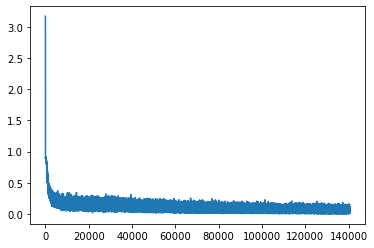

In [55]:
def train(layers,X_train,y_train,batch_size,learning_rate,epochs):
    start = time.time()
    losses = []
    X_t=X_train
    y_t=y_train
    numBatches = int(len(X_t)/batch_size)
    elementCount = 0
       
    for e in range(epochs):
        randomize = np.arange(len(X_t))
        np.random.shuffle(randomize)
        X_t = X_t[randomize]
        y_t = y_t[randomize]
        correctPredictions = 0
        incorrectPredictions = 0
        elementCount=0
        #For each batch: Forward pass - Calculate Loss - Calculate Deltas - Update weights 
        for x in range(numBatches):
            currentElement = 0
            X=X_t[elementCount:elementCount+batch_size]
            y=y_t[elementCount:elementCount+batch_size]
    
            layers = forwardPass(layers,X)
        
            losses.append(sum(meanSquaredError(y,layers[-1].out.T,batch_size)))
        
            for predElement in range(len(X)):
                correctPredictions , incorrectPredictions=classify(makePrediction(layers[-1].out[:,currentElement]) ,y ,
                                                           currentElement,correctPredictions,incorrectPredictions)
        
                elementCount+=1
                currentElement+=1
        
            layers = calculateDeltas(layers,y,batch_size)  
            layers = updateWeights(layers,X,learning_rate)
 
        if (len(X)%batch_size !=0):   #One last batch with less data
            X=X_t[elementCount:]
            y=y_t[elementCount:]
            currentElement = 0
            layers = forwardPass(layers,X)
            losses.append(sum(meanSquaredError(y,layers[-1].out.T,len(X))))
            for predElement in range(len(X)):
                correctPredictions, incorrectPredictions= classify(makePrediction(layers[-1].out[:,currentElement]) ,y ,
                                                          currentElement,correctPredictions,incorrectPredictions)        
                elementCount+=1
                currentElement+=1      
            layers = calculateDeltas(layers,y,len(X))
            layers = updateWeights(layers,X,learning_rate)
        #if (e%25==0):
        print("Epoch ",e+1,"/",epochs,".  Accuracy = ",(correctPredictions*100)/(correctPredictions+incorrectPredictions),"%")
    print("------------------------------")
    print("Epoch ",e+1,"/",epochs,".  Accuracy = ",float("{:.2f}".format((correctPredictions*100)/(correctPredictions+incorrectPredictions))),"%")
    print("Training Loss: ",float("{:.3f}".format(losses[-1])))
    plt.plot(losses)
    plt.show()
    end = time.time()
    print("Batch size: ",batch_size," | Learning Rate: ",learning_rate," | Epochs: ",epochs ," | No Of Layers: ",len(layers))
    for info in range(len(layers) -1):
        print("Hidden Layer ",info+1," neurons: ",layers[info].nodes,".")
    print("Training time: ",float("{:.2f}".format(end - start))," Seconds")
    return layers
#Forward pass for each element and check if our prediction matches its y value
def test(layers,X_test,y_test):
    correctPredictions=0
    incorrectPredictions=0
    X_testModel=X_test
    y_testModel=y_test
    for x in range(len(X_testModel)):
        layers = forwardPass(layers,X_testModel[x])    
        prediction = makePrediction(layers[-1].out)
        if (y_testModel[x][prediction]>0):
            correctPredictions+=1
        else:
            incorrectPredictions+=1
    print("Test Accuracy: ",float("{:.2f}".format( (correctPredictions*100)/(correctPredictions+incorrectPredictions))),"%")
    #print("------------------------------")
    

Epoch  1 / 350 .  Accuracy =  74.04282283884739 %
Epoch  2 / 350 .  Accuracy =  87.29489060832444 %
Epoch  3 / 350 .  Accuracy =  88.84738527214515 %
Epoch  4 / 350 .  Accuracy =  89.55276147278549 %
Epoch  5 / 350 .  Accuracy =  89.97298559231591 %
Epoch  6 / 350 .  Accuracy =  90.30149413020277 %
Epoch  7 / 350 .  Accuracy =  90.61999733191035 %
Epoch  8 / 350 .  Accuracy =  90.80843116328708 %
Epoch  9 / 350 .  Accuracy =  91.01020544290289 %
Epoch  10 / 350 .  Accuracy =  91.10192102454643 %
Epoch  11 / 350 .  Accuracy =  91.30202774813233 %
Epoch  12 / 350 .  Accuracy =  91.4004135538954 %
Epoch  13 / 350 .  Accuracy =  91.49379669156883 %
Epoch  14 / 350 .  Accuracy =  91.53381803628602 %
Epoch  15 / 350 .  Accuracy =  91.6705576307364 %
Epoch  16 / 350 .  Accuracy =  91.79562433297758 %
Epoch  17 / 350 .  Accuracy =  91.86399413020277 %
Epoch  18 / 350 .  Accuracy =  91.89234258271078 %
Epoch  19 / 350 .  Accuracy =  92.00573639274279 %
Epoch  20 / 350 .  Accuracy =  92.04742529

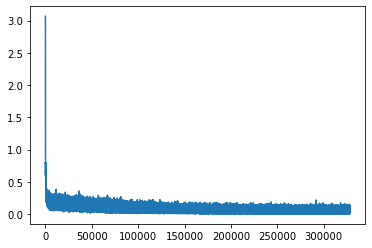

Batch size:  64  | Learning Rate:  0.1  | Epochs:  350  | No Of Layers:  2
Hidden Layer  1  neurons:  256 .
Training time:  1413.88  Seconds
Test Accuracy:  96.7 %


In [81]:
#Τrain and test our network for specific parameters (Serves as the main function of the program)
layers = []
hidden1= Layer(784,256)
layers.append(hidden1)



outLayer= Layer(256,10)

layers.append(outLayer)
batch_size = 64
learning_rate = 0.1   # β
epochs = 350

layers = train(layers,X_train,y_train,batch_size,learning_rate,epochs)
test(layers,X_test,y_test)

Epoch  1 / 150 .  Accuracy =  57.108333333333334 %
Epoch  2 / 150 .  Accuracy =  86.83333333333333 %
Epoch  3 / 150 .  Accuracy =  89.415 %
Epoch  4 / 150 .  Accuracy =  90.28 %
Epoch  5 / 150 .  Accuracy =  90.84 %
Epoch  6 / 150 .  Accuracy =  91.16333333333333 %
Epoch  7 / 150 .  Accuracy =  91.42 %
Epoch  8 / 150 .  Accuracy =  91.625 %
Epoch  9 / 150 .  Accuracy =  91.71666666666667 %
Epoch  10 / 150 .  Accuracy =  91.93666666666667 %
Epoch  11 / 150 .  Accuracy =  91.99833333333333 %
Epoch  12 / 150 .  Accuracy =  92.16166666666666 %
Epoch  13 / 150 .  Accuracy =  92.26666666666667 %
Epoch  14 / 150 .  Accuracy =  92.38 %
Epoch  15 / 150 .  Accuracy =  92.46 %
Epoch  16 / 150 .  Accuracy =  92.54666666666667 %
Epoch  17 / 150 .  Accuracy =  92.61666666666666 %
Epoch  18 / 150 .  Accuracy =  92.71666666666667 %
Epoch  19 / 150 .  Accuracy =  92.79166666666667 %
Epoch  20 / 150 .  Accuracy =  93.01166666666667 %
Epoch  21 / 150 .  Accuracy =  93.01166666666667 %
Epoch  22 / 150 .  

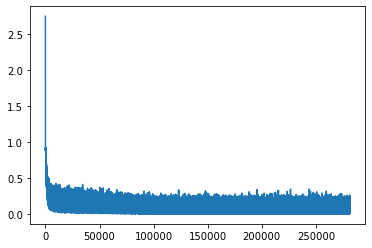

Batch size:  32  | Learning Rate:  0.1  | Epochs:  150  | No Of Layers:  3
Hidden Layer  1  neurons:  256 .
Hidden Layer  2  neurons:  256 .
Training time:  1244.33  Seconds
Test Accuracy:  95.27 %
Epoch  1 / 150 .  Accuracy =  40.7017075773746 %
Epoch  2 / 150 .  Accuracy =  77.51800960512273 %
Epoch  3 / 150 .  Accuracy =  85.6990394877268 %
Epoch  4 / 150 .  Accuracy =  88.35712379935966 %
Epoch  5 / 150 .  Accuracy =  89.1775613660619 %
Epoch  6 / 150 .  Accuracy =  89.80789754535752 %
Epoch  7 / 150 .  Accuracy =  90.17809498399146 %
Epoch  8 / 150 .  Accuracy =  90.63333778014942 %
Epoch  9 / 150 .  Accuracy =  90.83511205976521 %
Epoch  10 / 150 .  Accuracy =  90.9885272145144 %
Epoch  11 / 150 .  Accuracy =  91.16695570971184 %
Epoch  12 / 150 .  Accuracy =  91.35705709711846 %
Epoch  13 / 150 .  Accuracy =  91.44877267876201 %
Epoch  14 / 150 .  Accuracy =  91.54882604055496 %
Epoch  15 / 150 .  Accuracy =  91.64554429028816 %
Epoch  16 / 150 .  Accuracy =  91.7556029882604 %


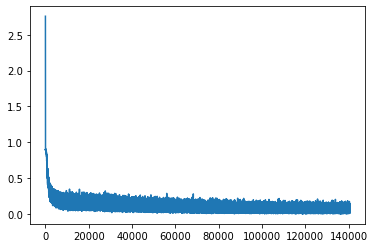

Batch size:  64  | Learning Rate:  0.1  | Epochs:  150  | No Of Layers:  3
Hidden Layer  1  neurons:  256 .
Hidden Layer  2  neurons:  256 .
Training time:  743.51  Seconds
Test Accuracy:  95.59 %
Epoch  1 / 150 .  Accuracy =  54.5 %
Epoch  2 / 150 .  Accuracy =  86.36166666666666 %
Epoch  3 / 150 .  Accuracy =  89.5 %
Epoch  4 / 150 .  Accuracy =  90.46 %
Epoch  5 / 150 .  Accuracy =  90.97833333333334 %
Epoch  6 / 150 .  Accuracy =  91.35 %
Epoch  7 / 150 .  Accuracy =  91.66 %
Epoch  8 / 150 .  Accuracy =  91.85333333333334 %
Epoch  9 / 150 .  Accuracy =  92.04166666666667 %
Epoch  10 / 150 .  Accuracy =  92.14666666666666 %
Epoch  11 / 150 .  Accuracy =  92.33166666666666 %
Epoch  12 / 150 .  Accuracy =  92.41666666666667 %
Epoch  13 / 150 .  Accuracy =  92.48666666666666 %
Epoch  14 / 150 .  Accuracy =  92.64166666666667 %
Epoch  15 / 150 .  Accuracy =  92.715 %
Epoch  16 / 150 .  Accuracy =  92.87166666666667 %
Epoch  17 / 150 .  Accuracy =  92.89166666666667 %
Epoch  18 / 150 . 

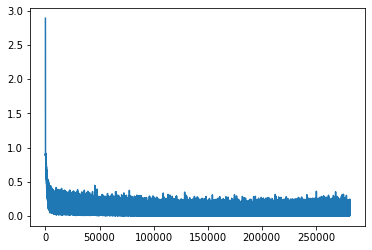

Batch size:  32  | Learning Rate:  0.1  | Epochs:  150  | No Of Layers:  3
Hidden Layer  1  neurons:  256 .
Hidden Layer  2  neurons:  128 .
Training time:  993.45  Seconds
Test Accuracy:  94.97 %
Epoch  1 / 150 .  Accuracy =  38.748999466382074 %
Epoch  2 / 150 .  Accuracy =  73.65094717182497 %
Epoch  3 / 150 .  Accuracy =  84.9503068303095 %
Epoch  4 / 150 .  Accuracy =  88.12700106723585 %
Epoch  5 / 150 .  Accuracy =  89.25593649946639 %
Epoch  6 / 150 .  Accuracy =  89.88293756670224 %
Epoch  7 / 150 .  Accuracy =  90.41155282817503 %
Epoch  8 / 150 .  Accuracy =  90.75340181430096 %
Epoch  9 / 150 .  Accuracy =  90.98352454642476 %
Epoch  10 / 150 .  Accuracy =  91.23532550693703 %
Epoch  11 / 150 .  Accuracy =  91.37540021344716 %
Epoch  12 / 150 .  Accuracy =  91.51213980789754 %
Epoch  13 / 150 .  Accuracy =  91.66555496264675 %
Epoch  14 / 150 .  Accuracy =  91.78895410885806 %
Epoch  15 / 150 .  Accuracy =  91.90735058697972 %
Epoch  16 / 150 .  Accuracy =  92.0340848452508

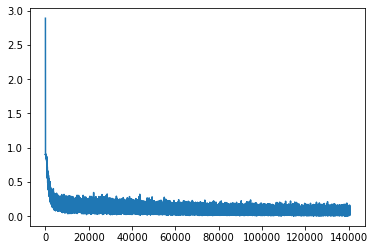

Batch size:  64  | Learning Rate:  0.1  | Epochs:  150  | No Of Layers:  3
Hidden Layer  1  neurons:  256 .
Hidden Layer  2  neurons:  128 .
Training time:  635.6  Seconds
Test Accuracy:  95.93 %
Epoch  1 / 150 .  Accuracy =  58.461666666666666 %
Epoch  2 / 150 .  Accuracy =  86.98166666666667 %
Epoch  3 / 150 .  Accuracy =  89.44166666666666 %
Epoch  4 / 150 .  Accuracy =  90.29333333333334 %
Epoch  5 / 150 .  Accuracy =  90.88666666666667 %
Epoch  6 / 150 .  Accuracy =  91.24333333333334 %
Epoch  7 / 150 .  Accuracy =  91.51166666666667 %
Epoch  8 / 150 .  Accuracy =  91.73 %
Epoch  9 / 150 .  Accuracy =  91.865 %
Epoch  10 / 150 .  Accuracy =  91.995 %
Epoch  11 / 150 .  Accuracy =  92.13166666666666 %
Epoch  12 / 150 .  Accuracy =  92.31833333333333 %
Epoch  13 / 150 .  Accuracy =  92.42833333333333 %
Epoch  14 / 150 .  Accuracy =  92.43333333333334 %
Epoch  15 / 150 .  Accuracy =  92.60666666666667 %
Epoch  16 / 150 .  Accuracy =  92.675 %
Epoch  17 / 150 .  Accuracy =  92.7333333

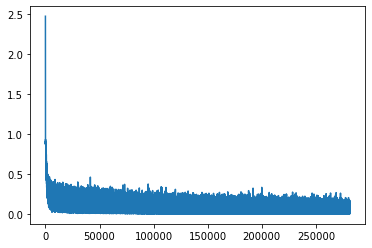

Batch size:  32  | Learning Rate:  0.1  | Epochs:  150  | No Of Layers:  3
Hidden Layer  1  neurons:  512 .
Hidden Layer  2  neurons:  256 .
Training time:  2676.25  Seconds
Test Accuracy:  95.93 %
Epoch  1 / 150 .  Accuracy =  41.81063233724653 %
Epoch  2 / 150 .  Accuracy =  78.62026414087514 %
Epoch  3 / 150 .  Accuracy =  86.24266275346852 %
Epoch  4 / 150 .  Accuracy =  88.38380469583778 %
Epoch  5 / 150 .  Accuracy =  89.26760939167556 %
Epoch  6 / 150 .  Accuracy =  89.90795090715048 %
Epoch  7 / 150 .  Accuracy =  90.29815901814301 %
Epoch  8 / 150 .  Accuracy =  90.60332177161153 %
Epoch  9 / 150 .  Accuracy =  90.8551227321238 %
Epoch  10 / 150 .  Accuracy =  91.02021077908218 %
Epoch  11 / 150 .  Accuracy =  91.22365261472785 %
Epoch  12 / 150 .  Accuracy =  91.3720651013874 %
Epoch  13 / 150 .  Accuracy =  91.50213447171825 %
Epoch  14 / 150 .  Accuracy =  91.62886872998932 %
Epoch  15 / 150 .  Accuracy =  91.73392475987193 %
Epoch  16 / 150 .  Accuracy =  91.82230522945571

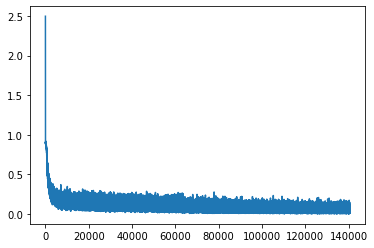

Batch size:  64  | Learning Rate:  0.1  | Epochs:  150  | No Of Layers:  3
Hidden Layer  1  neurons:  512 .
Hidden Layer  2  neurons:  256 .
Training time:  1551.74  Seconds
Test Accuracy:  95.95 %
Epoch  1 / 150 .  Accuracy =  60.24166666666667 %
Epoch  2 / 150 .  Accuracy =  87.36333333333333 %
Epoch  3 / 150 .  Accuracy =  89.49333333333334 %
Epoch  4 / 150 .  Accuracy =  90.37166666666667 %
Epoch  5 / 150 .  Accuracy =  90.79333333333334 %
Epoch  6 / 150 .  Accuracy =  91.24666666666667 %
Epoch  7 / 150 .  Accuracy =  91.47166666666666 %
Epoch  8 / 150 .  Accuracy =  91.675 %
Epoch  9 / 150 .  Accuracy =  91.86166666666666 %
Epoch  10 / 150 .  Accuracy =  92.05 %
Epoch  11 / 150 .  Accuracy =  92.18166666666667 %
Epoch  12 / 150 .  Accuracy =  92.32333333333334 %
Epoch  13 / 150 .  Accuracy =  92.46166666666667 %
Epoch  14 / 150 .  Accuracy =  92.60833333333333 %
Epoch  15 / 150 .  Accuracy =  92.69666666666667 %
Epoch  16 / 150 .  Accuracy =  92.805 %
Epoch  17 / 150 .  Accuracy =

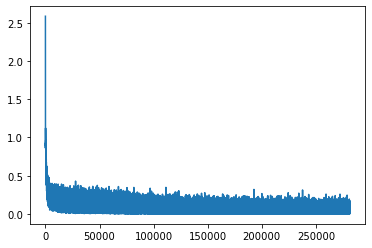

Batch size:  32  | Learning Rate:  0.1  | Epochs:  150  | No Of Layers:  3
Hidden Layer  1  neurons:  784 .
Hidden Layer  2  neurons:  784 .
Training time:  5201.77  Seconds
Test Accuracy:  96.02 %
Epoch  1 / 150 .  Accuracy =  42.707777481323376 %
Epoch  2 / 150 .  Accuracy =  81.47678762006403 %
Epoch  3 / 150 .  Accuracy =  86.79295624332977 %
Epoch  4 / 150 .  Accuracy =  88.56056563500533 %
Epoch  5 / 150 .  Accuracy =  89.36266008537886 %
Epoch  6 / 150 .  Accuracy =  89.73619263607257 %
Epoch  7 / 150 .  Accuracy =  90.241462113127 %
Epoch  8 / 150 .  Accuracy =  90.57997598719317 %
Epoch  9 / 150 .  Accuracy =  90.74339647812167 %
Epoch  10 / 150 .  Accuracy =  90.98685965848452 %
Epoch  11 / 150 .  Accuracy =  91.14027481323373 %
Epoch  12 / 150 .  Accuracy =  91.35038687299894 %
Epoch  13 / 150 .  Accuracy =  91.40541622198506 %
Epoch  14 / 150 .  Accuracy =  91.56883671291355 %
Epoch  15 / 150 .  Accuracy =  91.65888473852722 %
Epoch  16 / 150 .  Accuracy =  91.7556029882604

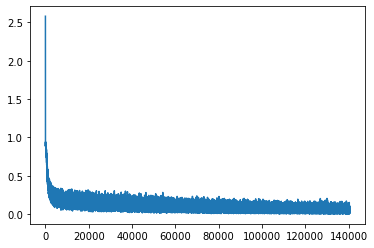

Batch size:  64  | Learning Rate:  0.1  | Epochs:  150  | No Of Layers:  3
Hidden Layer  1  neurons:  784 .
Hidden Layer  2  neurons:  784 .
Training time:  2987.17  Seconds
Test Accuracy:  95.89 %
Epoch  1 / 150 .  Accuracy =  16.128333333333334 %
Epoch  2 / 150 .  Accuracy =  63.31333333333333 %
Epoch  3 / 150 .  Accuracy =  81.88166666666666 %
Epoch  4 / 150 .  Accuracy =  86.80166666666666 %
Epoch  5 / 150 .  Accuracy =  88.33 %
Epoch  6 / 150 .  Accuracy =  89.345 %
Epoch  7 / 150 .  Accuracy =  89.99333333333334 %
Epoch  8 / 150 .  Accuracy =  90.475 %
Epoch  9 / 150 .  Accuracy =  90.83833333333334 %
Epoch  10 / 150 .  Accuracy =  91.23166666666667 %
Epoch  11 / 150 .  Accuracy =  91.5 %
Epoch  12 / 150 .  Accuracy =  91.81333333333333 %
Epoch  13 / 150 .  Accuracy =  92.07666666666667 %
Epoch  14 / 150 .  Accuracy =  92.235 %
Epoch  15 / 150 .  Accuracy =  92.43833333333333 %
Epoch  16 / 150 .  Accuracy =  92.57666666666667 %
Epoch  17 / 150 .  Accuracy =  92.78166666666667 %
E

<ipython-input-6-74113d9be9e9>:21: RuntimeWarning: overflow encountered in exp
  out = 1/(1+np.exp(-x))


Epoch  104 / 150 .  Accuracy =  90.34666666666666 %
Epoch  105 / 150 .  Accuracy =  88.365 %
Epoch  106 / 150 .  Accuracy =  83.23333333333333 %
Epoch  107 / 150 .  Accuracy =  78.20333333333333 %
Epoch  108 / 150 .  Accuracy =  75.11666666666666 %
Epoch  109 / 150 .  Accuracy =  76.055 %
Epoch  110 / 150 .  Accuracy =  73.64166666666667 %
Epoch  111 / 150 .  Accuracy =  71.11 %
Epoch  112 / 150 .  Accuracy =  71.49 %
Epoch  113 / 150 .  Accuracy =  72.85333333333334 %
Epoch  114 / 150 .  Accuracy =  74.03666666666666 %
Epoch  115 / 150 .  Accuracy =  72.90166666666667 %
Epoch  116 / 150 .  Accuracy =  69.90833333333333 %
Epoch  117 / 150 .  Accuracy =  72.40666666666667 %
Epoch  118 / 150 .  Accuracy =  71.79333333333334 %
Epoch  119 / 150 .  Accuracy =  68.025 %
Epoch  120 / 150 .  Accuracy =  64.71 %
Epoch  121 / 150 .  Accuracy =  62.211666666666666 %
Epoch  122 / 150 .  Accuracy =  55.955 %
Epoch  123 / 150 .  Accuracy =  53.778333333333336 %
Epoch  124 / 150 .  Accuracy =  58.103

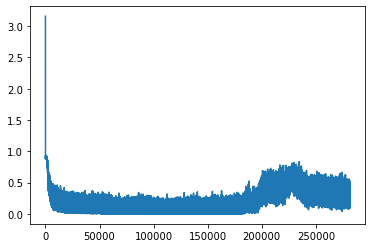

Batch size:  32  | Learning Rate:  0.1  | Epochs:  150  | No Of Layers:  4
Hidden Layer  1  neurons:  256 .
Hidden Layer  2  neurons:  256 .
Hidden Layer  3  neurons:  256 .
Training time:  1642.68  Seconds
Test Accuracy:  82.09 %
Epoch  1 / 150 .  Accuracy =  11.409418356456777 %
Epoch  2 / 150 .  Accuracy =  23.83437833511206 %
Epoch  3 / 150 .  Accuracy =  56.72358591248666 %
Epoch  4 / 150 .  Accuracy =  71.65821771611526 %
Epoch  5 / 150 .  Accuracy =  80.17275880469583 %
Epoch  6 / 150 .  Accuracy =  84.45837780149412 %
Epoch  7 / 150 .  Accuracy =  86.63954108858057 %
Epoch  8 / 150 .  Accuracy =  87.61672892209178 %
Epoch  9 / 150 .  Accuracy =  88.27374599786553 %
Epoch  10 / 150 .  Accuracy =  88.90241462113127 %
Epoch  11 / 150 .  Accuracy =  89.31263340448238 %
Epoch  12 / 150 .  Accuracy =  89.69617129135538 %
Epoch  13 / 150 .  Accuracy =  89.80789754535752 %
Epoch  14 / 150 .  Accuracy =  90.14974653148346 %
Epoch  15 / 150 .  Accuracy =  90.36152614727855 %
Epoch  16 / 

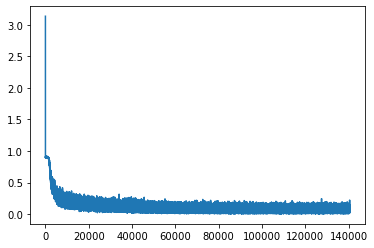

Batch size:  64  | Learning Rate:  0.1  | Epochs:  150  | No Of Layers:  4
Hidden Layer  1  neurons:  256 .
Hidden Layer  2  neurons:  256 .
Hidden Layer  3  neurons:  256 .
Training time:  1088.83  Seconds
Test Accuracy:  95.2 %
Epoch  1 / 150 .  Accuracy =  26.255 %
Epoch  2 / 150 .  Accuracy =  35.855 %
Epoch  3 / 150 .  Accuracy =  34.655 %
Epoch  4 / 150 .  Accuracy =  34.85166666666667 %
Epoch  5 / 150 .  Accuracy =  34.35666666666667 %
Epoch  6 / 150 .  Accuracy =  34.858333333333334 %
Epoch  7 / 150 .  Accuracy =  34.93833333333333 %
Epoch  8 / 150 .  Accuracy =  34.14833333333333 %
Epoch  9 / 150 .  Accuracy =  36.53 %
Epoch  10 / 150 .  Accuracy =  37.623333333333335 %
Epoch  11 / 150 .  Accuracy =  37.48 %
Epoch  12 / 150 .  Accuracy =  37.055 %
Epoch  13 / 150 .  Accuracy =  37.196666666666665 %
Epoch  14 / 150 .  Accuracy =  37.903333333333336 %
Epoch  15 / 150 .  Accuracy =  38.568333333333335 %
Epoch  16 / 150 .  Accuracy =  39.725 %
Epoch  17 / 150 .  Accuracy =  41.963

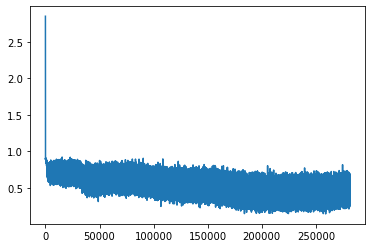

Batch size:  32  | Learning Rate:  0.1  | Epochs:  150  | No Of Layers:  3
Hidden Layer  1  neurons:  256 .
Hidden Layer  2  neurons:  10 .
Training time:  1254.86  Seconds
Test Accuracy:  68.26 %
Epoch  1 / 150 .  Accuracy =  18.38647278548559 %
Epoch  2 / 150 .  Accuracy =  34.04148879402348 %
Epoch  3 / 150 .  Accuracy =  36.534485058697975 %
Epoch  4 / 150 .  Accuracy =  35.432230522945574 %
Epoch  5 / 150 .  Accuracy =  34.7101787620064 %
Epoch  6 / 150 .  Accuracy =  34.51840981856991 %
Epoch  7 / 150 .  Accuracy =  34.48339114194237 %
Epoch  8 / 150 .  Accuracy =  34.588447171824974 %
Epoch  9 / 150 .  Accuracy =  34.353321771611526 %
Epoch  10 / 150 .  Accuracy =  34.405016008537885 %
Epoch  11 / 150 .  Accuracy =  34.53341782283885 %
Epoch  12 / 150 .  Accuracy =  34.521744930629666 %
Epoch  13 / 150 .  Accuracy =  34.62346584845251 %
Epoch  14 / 150 .  Accuracy =  34.10985859124867 %
Epoch  15 / 150 .  Accuracy =  33.81803628601921 %
Epoch  16 / 150 .  Accuracy =  34.72518676

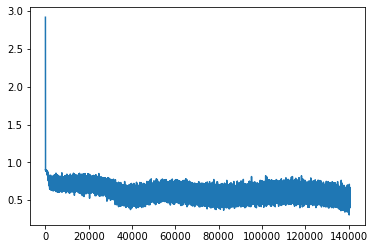

Batch size:  64  | Learning Rate:  0.1  | Epochs:  150  | No Of Layers:  3
Hidden Layer  1  neurons:  256 .
Hidden Layer  2  neurons:  10 .
Training time:  844.14  Seconds
Test Accuracy:  64.64 %
Epoch  1 / 150 .  Accuracy =  14.205 %
Epoch  2 / 150 .  Accuracy =  52.94166666666667 %
Epoch  3 / 150 .  Accuracy =  76.095 %
Epoch  4 / 150 .  Accuracy =  83.54333333333334 %
Epoch  5 / 150 .  Accuracy =  86.29833333333333 %
Epoch  6 / 150 .  Accuracy =  87.975 %
Epoch  7 / 150 .  Accuracy =  89.01166666666667 %
Epoch  8 / 150 .  Accuracy =  89.66 %
Epoch  9 / 150 .  Accuracy =  90.30166666666666 %
Epoch  10 / 150 .  Accuracy =  90.71333333333334 %
Epoch  11 / 150 .  Accuracy =  90.88166666666666 %
Epoch  12 / 150 .  Accuracy =  91.18666666666667 %
Epoch  13 / 150 .  Accuracy =  91.33833333333334 %
Epoch  14 / 150 .  Accuracy =  91.41666666666667 %
Epoch  15 / 150 .  Accuracy =  91.455 %
Epoch  16 / 150 .  Accuracy =  91.25833333333334 %
Epoch  17 / 150 .  Accuracy =  90.99666666666667 %
Ep

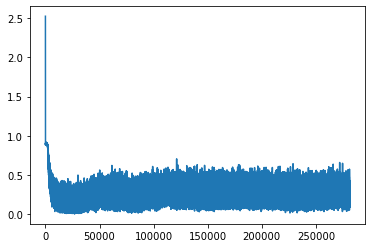

Batch size:  32  | Learning Rate:  0.1  | Epochs:  150  | No Of Layers:  4
Hidden Layer  1  neurons:  256 .
Hidden Layer  2  neurons:  128 .
Hidden Layer  3  neurons:  64 .
Training time:  1414.21  Seconds
Test Accuracy:  84.08 %
Epoch  1 / 150 .  Accuracy =  11.479455709711846 %
Epoch  2 / 150 .  Accuracy =  19.26860992529349 %
Epoch  3 / 150 .  Accuracy =  45.08571237993596 %
Epoch  4 / 150 .  Accuracy =  62.438300426894344 %
Epoch  5 / 150 .  Accuracy =  72.40194770544291 %
Epoch  6 / 150 .  Accuracy =  80.12940234791888 %
Epoch  7 / 150 .  Accuracy =  82.90921824973319 %
Epoch  8 / 150 .  Accuracy =  84.4517075773746 %
Epoch  9 / 150 .  Accuracy =  85.67736125933831 %
Epoch  10 / 150 .  Accuracy =  86.98472518676627 %
Epoch  11 / 150 .  Accuracy =  87.86019210245465 %
Epoch  12 / 150 .  Accuracy =  88.46384738527215 %
Epoch  13 / 150 .  Accuracy =  88.92242529348987 %
Epoch  14 / 150 .  Accuracy =  89.3009605122732 %
Epoch  15 / 150 .  Accuracy =  89.66782283884739 %
Epoch  16 / 15

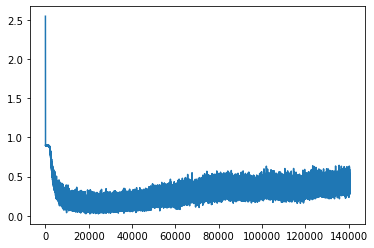

Batch size:  64  | Learning Rate:  0.1  | Epochs:  150  | No Of Layers:  4
Hidden Layer  1  neurons:  256 .
Hidden Layer  2  neurons:  128 .
Hidden Layer  3  neurons:  64 .
Training time:  865.51  Seconds
Test Accuracy:  69.08 %


In [73]:
#Trains and tests the network for numerous layer and batch_size combinations.
import copy

layers= [Layer(784,256),Layer(256,256),Layer(256,10)]
layers2= [Layer(784,256),Layer(256,128),Layer(128,10)]
layers3= [Layer(784,512),Layer(512,256),Layer(256,10)]
layers4= [Layer(784,784),Layer(784,784),Layer(784,10)]
layers5= [Layer(784,256),Layer(256,256),Layer(256,256),Layer(256,10)]
layers6= [Layer(784,256),Layer(256,10),Layer(10,10)]
layers7= [Layer(784,256),Layer(256,128),Layer(128,64),Layer(64,10)]
#layers5= [Layer(784,784),Layer(784,784),Layer(784,10)]
#layers6= [Layer(784,1000),Layer(1000,10)]
#layers7= [Layer(784,400),Layer(400,10)]
#layers8= [Layer(784,400),Layer(400,200),Layer(200,10)]
#layers9= [Layer(784,512),Layer(512,256),Layer(256,64),Layer(64,10)]
#layers10= [Layer(784,10),Layer(10,10)]
#layers11= [Layer(784,10)]

batch_list = [32,64]

L_list= [layers,layers2,layers3,layers4,layers5,layers6,layers7]
#L_list2= [layers2,layers3,layers4]

for layer in L_list:
    for batch in batch_list:
        original = copy.deepcopy(layer)
        result = train(layer,X_train,y_train,batch,0.1,150)
        test(result,X_test,y_test)
        layer = copy.deepcopy(original)
        